In [1]:
import pickle
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
os.chdir('..')
from star_sample import Isochrones,StarSample
os.chdir('Data')
pkl_file = open('isochrones_cluster.pkl', 'rb')
Isochrone_cluster = pickle.load(pkl_file)

pkl_file = open('cluster_values.pkl', 'rb')
Cluster_sample = pickle.load(pkl_file)


os.chdir('..')

# Perpendicular Distance

We want to check the perpendicular distance from the isochrone to see if it is giving us something reasonable.

Add on the absolute magnitude

Important to note that I haven't calculated selection error and propegated that forward. This error will essentially be absorbed into the error of making distance, feh and age constant.

In [2]:
Cluster_sample.mean_absolute_mag_g_band(abs_column_name='G',magnitude_column='phot_g_mean_mag',parallax_column='parallax')

Becasue we assume a constant distance, the error of the absolute magnitude simply becomes the error of the apperant magnitude.

In [3]:

Cluster_sample.data['G']=Cluster_sample.data['phot_g_mean_mag']-5*np.log10((Cluster_sample.data['rgeo']*1000.0)/10.0)

### Move the values to account for extinction.

In [4]:
E=0.6
Cluster_sample.data['G']=Cluster_sample.data['G']-2*E
Cluster_sample.data['bp_rp']=Cluster_sample.data['bp_rp']-E

Take a subsample

In [5]:
Cluster_sample.data[Cluster_sample.data['G']<=6.0].reset_index(drop=True,inplace=True)
Cluster_sample.data[Cluster_sample.data['G']>=0.0].reset_index(drop=True,inplace=True)

Stack the isochrones.

In [6]:
stacked_isochrones=Isochrone_cluster.stack_isochrones()#_subsample(feh_list,age_list)


Turn the cluster sample into a tensor.

In [7]:
x_values=Cluster_sample.to_tensor(expandsize=stacked_isochrones.shape[-2])

We are going to assume that the age and feh are the literature values of the cluster for each member of the cluster.

In [8]:
age_list=[8.6]
feh_list=[0.17 for i in range(len(x_values))]#Cluster_sample.data['mh_gspphot']
stacked_isochrones=Isochrone_cluster.stack_isochrones_subsample(feh_list,age_list)

In [9]:
x_columns=Cluster_sample.data.columns
isoc_columns=Isochrone_cluster.isochrones_list[0].columns
def column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0] +len(x_columns)

Concatenate the cluster values and the isochrone values so we can find the perpendicular distance.

In [10]:
isochrone=torch.cat([x_values,stacked_isochrones],dim=-1)

isochrone.shape

torch.Size([1066, 217, 42])

# Perpendicular distance algorithm

In [11]:
Isochrone_cluster.isochrones_list[Isochrone_cluster.isochrone_selector(torch.tensor([0.17]),torch.tensor([8.6]))]

,logg,logteff,logl,mass,logage,feh,phase,Gaia_G_EDR3,Gaia_RP_EDR3,Gaia_BP_EDR3,BPRP,p_slopes,slopes,low_c,high_c
0,4.960244,3.503368,-2.092237,0.290290,8.555556,0.17,0.0,11.095018,9.887057,12.652871,2.765814,-0.370466,2.699304,11.902136,12.119658
1,4.952280,3.508568,-2.033428,0.310310,8.555556,0.17,0.0,10.903748,9.712402,12.407356,2.694955,-0.378806,2.639871,11.690373,11.924614
2,4.943505,3.515100,-1.971373,0.330330,8.555556,0.17,0.0,10.698901,9.527704,12.145061,2.617358,-0.377952,2.645839,11.444218,11.688137
3,4.931571,3.521924,-1.906587,0.350350,8.555556,0.17,0.0,10.485471,9.335193,11.871884,2.536691,-0.404831,2.470168,11.257869,11.512401
4,4.920682,3.529393,-1.841688,0.370370,8.555556,0.17,0.0,10.266779,9.139432,11.587591,2.448158,-0.423416,2.361744,11.034757,11.303368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,3.675585,3.964392,2.044629,2.952953,8.555556,0.17,0.0,-0.280896,-0.282028,-0.280502,0.001526,0.119803,-8.347059,-0.336032,-0.281078
134,3.648897,3.961146,2.061323,2.972973,8.555556,0.17,0.0,-0.335072,-0.340504,-0.332488,0.008016,0.132121,-7.568802,-0.393286,-0.336131
135,3.620245,3.957420,2.078062,2.992993,8.555556,0.17,0.0,-0.391246,-0.401592,-0.386154,0.015438,0.150212,-6.657245,-0.450034,-0.393565
136,3.590946,3.953382,2.094076,3.013013,8.555556,0.17,0.0,-0.446469,-0.462299,-0.438566,0.023733,0.183325,-5.454803,-0.506809,-0.450820


In [12]:

truth_1=(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')]<=isochrone[:,:,column_index('high_c')]) #box selection
truth_2=(isochrone[:,:,column_index('low_c')]<=isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')])
truth=torch.logical_and(truth_1,truth_2)


# projection onto the nearest line
x=((1/torch.sqrt(1+isochrone[:,:,column_index('slopes')]**2))*(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('slopes')]-isochrone[:,:,column_index('Gaia_G_EDR3')] + isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('BPRP')]))

print(torch.abs(x/truth.reshape(x.shape))[23])
idx=torch.argmin(torch.abs(x/truth.reshape(x.shape)).nan_to_num(nan=torch.inf),-1)
x=x.gather(1,idx.view(-1,1))
#error needs to be corrected for absolute magnitude 
x_err=(1/(1+isochrone[:,:,column_index('slopes')]**2))*(isochrone[:,:,column_index('phot_g_mean_mag_error')]**2+(isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('bp_rp_error')])**2)
x_err=x_err.gather(1,idx.view(-1,1))

         

tensor([   inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf, 0.0753,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,    inf,
           inf,    inf,    inf,    inf, 

In [13]:
idx[23]

tensor(94)

In [14]:
Cluster_sample.data['perp']=np.array(x)
Cluster_sample.data['perp_err']=np.array(x_err)
Cluster_sample.data['idx']=np.array(idx)

In [15]:
Cluster_sample.data=Cluster_sample.data[Cluster_sample.data['idx']!=0].reset_index(drop=True)

# Perpendicular distance plot

We are hoping that the distribution shoudl look like this. In this idea, later we will take a group of stars in a high galactic latitdue region, do the same thing with their parameters, marginalise over age and find the distance along the reddening vector.

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


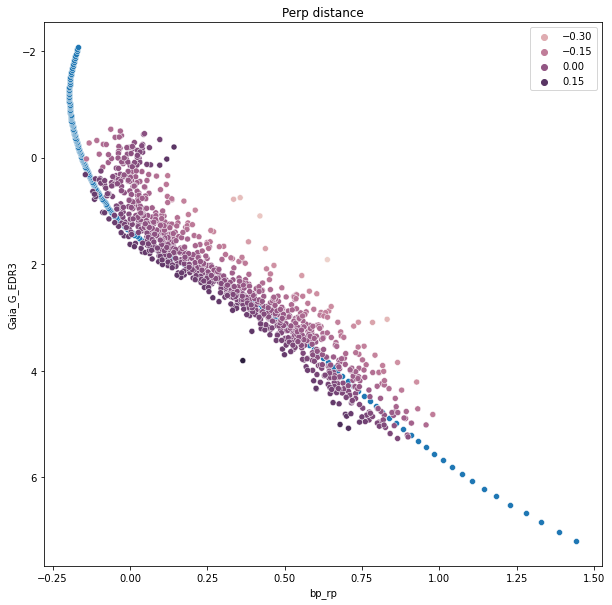

In [16]:
title='Perp distance'
mag_column='G'
colour_column='bp_rp'
hue_column='perp'
height=10
width=10
isochrone=Isochrone_cluster.isochrones_list[0]
f, axes = plt.subplots(1, 1)
f.set_figheight(height)
f.set_figwidth(width)
sn.scatterplot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3']
                                )
sn.scatterplot(x=Cluster_sample.data[colour_column],y=Cluster_sample.data[mag_column],hue=Cluster_sample.data[hue_column])#,kwargs=kwargs)



axes.invert_yaxis()
plt.legend()
axes.set_title(title)
plt.show()

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


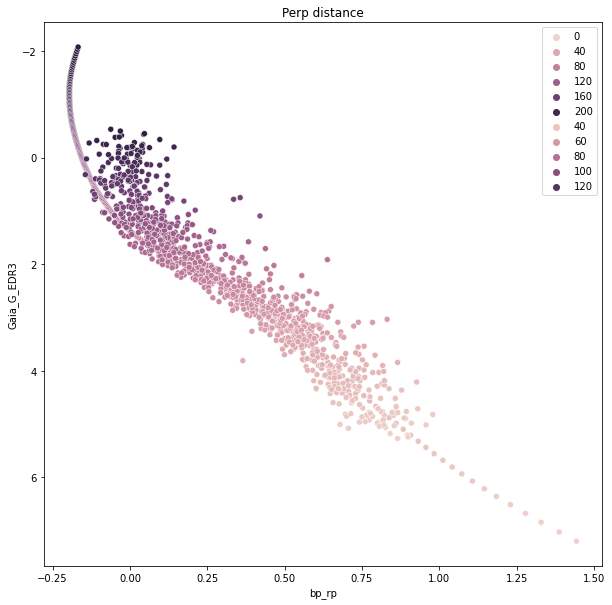

In [17]:
title='Perp distance'
mag_column='G'
colour_column='bp_rp'
hue_column='perp'
height=10
width=10
isochrone=Isochrone_cluster.isochrones_list[0]
f, axes = plt.subplots(1, 1)
f.set_figheight(height)
f.set_figwidth(width)
sn.scatterplot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],hue=isochrone.index
                                )
sn.scatterplot(x=Cluster_sample.data[colour_column],y=Cluster_sample.data[mag_column],hue=Cluster_sample.data['idx'])#,kwargs=kwargs)



axes.invert_yaxis()
plt.legend()
axes.set_title(title)
plt.show()

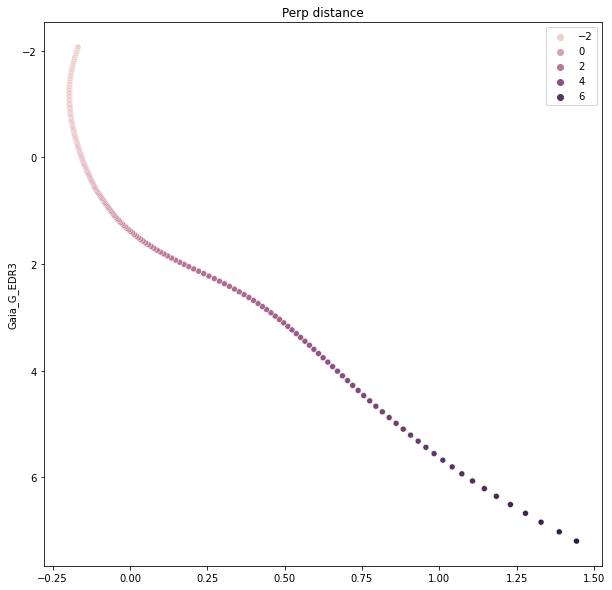

In [18]:
title='Perp distance'
mag_column='G'
colour_column='bp_rp'
hue_column='perp'
height=10
width=10
isochrone=Isochrone_cluster.isochrones_list[0]

f, axes = plt.subplots(1, 1)
f.set_figheight(height)
f.set_figwidth(width)
#sn.scatterplot(x=(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3']), y=isochrone['Gaia_G_EDR3']
#                              )

sn.scatterplot(x=(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3']), y=isochrone['Gaia_G_EDR3'], hue=(isochrone['high_c'])
                              )
#sn.scatterplot(x=Cluster_sample.data[colour_column],y=Cluster_sample.data[mag_column],hue=Cluster_sample.data[hue_column])#,kwargs=kwargs)
axes.invert_yaxis()

plt.legend()
axes.set_title(title)
plt.show()

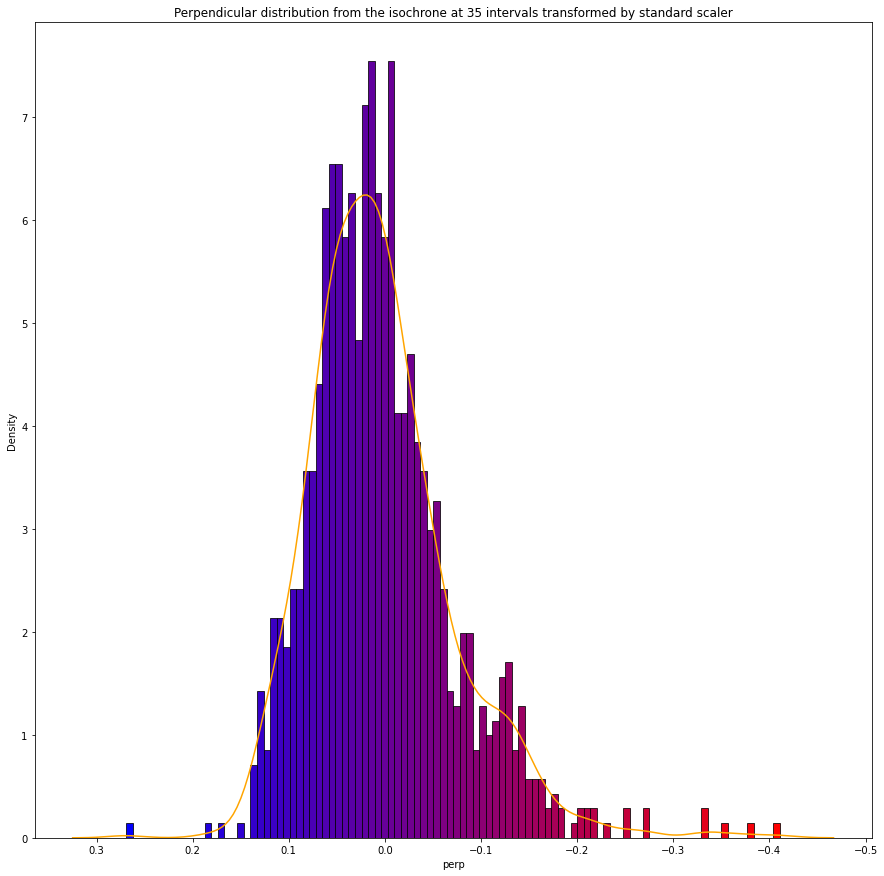

In [19]:

f, ax = plt.subplots(1, 1, figsize=(15,15))
plt.title('Perpendicular distribution from the isochrone at 35 intervals transformed by standard scaler')
sn.histplot(Cluster_sample.data['perp'],ax=ax,kde=False,legend=False,bins=100,stat='density')
for i in range(0,100):
    ax.patches[i].set_facecolor([1-i/100,0,i/100])
sn.kdeplot(Cluster_sample.data['perp'],ax=ax,color='orange')
ax.invert_xaxis()
plt.show()

<AxesSubplot:xlabel='perp_err', ylabel='perp'>

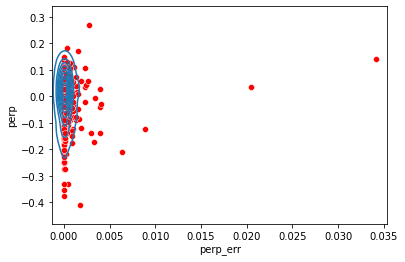

In [20]:

sn.scatterplot(data=Cluster_sample.data,x='perp_err',y='perp',color='r')
sn.kdeplot(data=Cluster_sample.data,x='perp_err',y='perp')

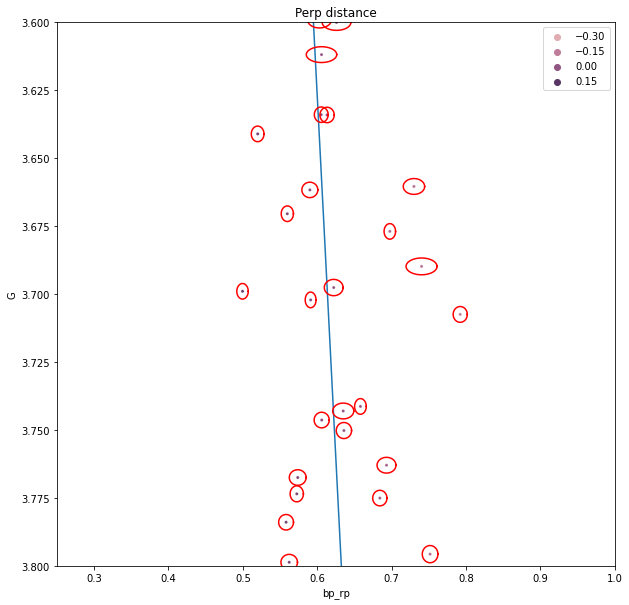

In [21]:
from math import pi



title='Perp distance'
mag_column='G'
colour_column='bp_rp'
hue_column='perp'
height=10
width=10
isochrone=Isochrone_cluster.isochrones_list[0]
f, axes = plt.subplots(1, 1)
f.set_figheight(height)
f.set_figwidth(width)
plt.plot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3']
                                )
sn.scatterplot(x=Cluster_sample.data[colour_column],y=Cluster_sample.data[mag_column],hue=Cluster_sample.data[hue_column],s=10)#,kwargs=kwargs)

for i in range(len(Cluster_sample.data)):
    u=Cluster_sample.data[colour_column][i]     #x-position of the center
    v=Cluster_sample.data[mag_column][i]    #y-position of the center
    a=np.abs(Cluster_sample.data['bp_rp_error'][i])     #radius on the x-axis
    b=np.abs(Cluster_sample.data['phot_g_mean_mag_error'][i])    #radius on the y-axis
    t = np.linspace(0, 2*pi, 100)
    plt.plot( u+a*np.cos(t) , v+b*np.sin(t) ,c='r')



axes.invert_yaxis()
plt.ylim(3.8,3.6)
plt.xlim(0.25,1)
plt.legend()
axes.set_title(title)
plt.show()

In [28]:
os.getcwd()
os.chdir('Data')

In [29]:
Cluster_sample.data.to_csv('prior_data')